# Project setup

## Dependencies

In [ ]:
# Cell 0: Installations

# Data ingestion
#%pip install scikit-learn scikit-image
#%pip install SimpleITK
#%pip install nibabel nilearn scipy scikit-image
#%pip install albumentations


In [2]:
# Cell 1: Import necessary libraries

# Dataset handling and ingestion
import os
import pandas as pd
import numpy as np

# Image processing
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars

# Exploratory data analysis
import time
import gc
import psutil
import torch
from scipy import stats

# Preprocessing
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy import ndimage
from scipy.ndimage import zoom
from skimage import filters
from skimage.morphology import binary_dilation, binary_erosion, ball
import nibabel as nib

## Dataset loading

In [3]:
# Cell 2: Load and process the CSV file with exam information
csv_path = os.path.join('Images', 'idaSearch.csv')
exam_info_df = pd.read_csv(csv_path)

# Cell 2: Define the base directory and categories
base_dir = 'Images'
categories = ['PPMI_Images_PD', 'PPMI_Images_SWEDD', 'PPMI_Images_Cont']

In [4]:
# Cell 3: Collect DICOM file paths for each category
data = []

for category in categories:
    category_path = os.path.join(base_dir, category)
    for patient_id in os.listdir(category_path):
        patient_path = os.path.join(category_path, patient_id)
        reconstructed_path = os.path.join(patient_path, 'Reconstructed_DaTSCAN')
        if os.path.exists(reconstructed_path):
            for exam_date in os.listdir(reconstructed_path):
                exam_date_path = os.path.join(reconstructed_path, exam_date)
                for exam_id in os.listdir(exam_date_path):
                    exam_id_path = os.path.join(exam_date_path, exam_id)
                    for root, dirs, files in os.walk(exam_id_path):
                        for file in files:
                            if file.endswith('.dcm'):
                                file_path = os.path.join(root, file)
                                # Controlliamo che non sia un'immagine raw
                                if 'br_raw_' not in file_path:
                                    data.append({
                                        'category': category,
                                        'patient_id': patient_id,
                                        'file_path': file_path
                                    })

In [5]:
# Cell 4: Create a DataFrame to organize the data
df = pd.DataFrame(data)
df['label'] = df['category'].map({
    'PPMI_Images_PD': 'PD',
    'PPMI_Images_SWEDD': 'SWEDD',
    'PPMI_Images_Cont': 'Control'
})
df = df[['patient_id', 'file_path', 'label']]

loaded_patients = df['patient_id'].unique()
print("\nLoading statistics:")
print(f"Total unique patients loaded: {len(loaded_patients)}")
print(f"Patients loaded per category:")
for category in df['label'].unique():
    cat_patients = df[df['label'] == category]['patient_id'].nunique()
    print(f"- {category}: {cat_patients} patients")


Loading statistics:
Total unique patients loaded: 1651
Patients loaded per category:
- PD: 1283 patients
- SWEDD: 79 patients
- Control: 289 patients


In [6]:
# Cell 5: Summary statistics
print('Number of images per category:')
print(df['label'].value_counts())
print('\nNumber of unique patients per category:')
for label in df['label'].unique():
    n_patients = df[df['label'] == label]['patient_id'].nunique()
    print(f"{label}: {n_patients} patients")


Number of images per category:
label
PD         2555
Control     294
SWEDD       137
Name: count, dtype: int64

Number of unique patients per category:
PD: 1283 patients
SWEDD: 79 patients
Control: 289 patients


In [7]:
# Cell 6: Save DataFrame to CSV (optional)
df.to_csv('dicom_file_paths.csv', index=False)

In [27]:
# Cell 7: Functions to load and preprocess DICOM images
def load_dicom_image(file_path, target_shape=None):
    """
    Load a DICOM file and return the image data as a NumPy array.
    Optionally resizes the image to the target_shape.
    """
    ds = pydicom.dcmread(file_path)
    img = ds.pixel_array.astype(np.float32)
    
    # Apply rescale slope and intercept if present
    if 'RescaleSlope' in ds:
        img *= float(ds.RescaleSlope)
    if 'RescaleIntercept' in ds:
        img += float(ds.RescaleIntercept)
    
    # Normalize the image intensities
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    # Resize image if target_shape is specified
    if target_shape and img.shape != target_shape:
        from skimage.transform import resize
        img = resize(img, target_shape, mode='reflect', anti_aliasing=True)
    
    return img

def print_dicom_orientation(dicom_path):
    """
    Stampa le informazioni di orientamento dal file DICOM
    """
    ds = pydicom.dcmread(dicom_path)
    print("\nDICOM Orientation Info:")
    for tag in ['ImageOrientationPatient', 'ImagePositionPatient', 'PixelSpacing']:
        if tag in ds:
            print(f"{tag}: {ds[tag].value}")

def debug_volume_visualization(mean_img, title="Debug Volume View"):
    """
    Visualize the 3D volume more appropriately for DATSCAN

    Visualizza il volume 3D in modo più appropriato per DATSCAN
    """
    print(f"Volume shape: {mean_img.shape}")
    
    # Extract the central planes in three directions
    center_x = mean_img.shape[0] // 2
    center_y = mean_img.shape[1] // 2
    center_z = mean_img.shape[2] // 2
    
    # Visualize raw data without manipulations
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"{title} - Raw Data Views")
    
    # First row: raw data
    axes[0,0].imshow(mean_img[center_x, :, :], cmap='gray')
    axes[0,0].set_title('YZ plane (raw)')
    axes[0,1].imshow(mean_img[:, center_y, :], cmap='gray')
    axes[0,1].set_title('XZ plane (raw)')
    axes[0,2].imshow(mean_img[:, :, center_z], cmap='gray')
    axes[0,2].set_title('XY plane (raw)')
    
    # Second row: histograms intensity distributions
    axes[1,0].hist(mean_img[center_x, :, :].ravel(), bins=50)
    axes[1,0].set_title('YZ intensity distribution')
    axes[1,1].hist(mean_img[:, center_y, :].ravel(), bins=50)
    axes[1,1].set_title('XZ intensity distribution')
    axes[1,2].hist(mean_img[:, :, center_z].ravel(), bins=50)
    axes[1,2].set_title('XY intensity distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Some statistics
    print("\nStatistics per plane:")
    print(f"YZ plane - min: {mean_img[center_x, :, :].min():.3f}, max: {mean_img[center_x, :, :].max():.3f}")
    print(f"XZ plane - min: {mean_img[:, center_y, :].min():.3f}, max: {mean_img[:, center_y, :].max():.3f}")
    print(f"XY plane - min: {mean_img[:, :, center_z].min():.3f}, max: {mean_img[:, :, center_z].max():.3f}")

    return mean_img

In [9]:
# Cell 8: Initialize dictionaries to store sums and counts for each group
mean_sums = {'PD': None, 'SWEDD': None, 'Control': None}
counts = {'PD': 0, 'SWEDD': 0, 'Control': 0}
shapes = {'PD': None, 'SWEDD': None, 'Control': None}


In [10]:
# Cell 9: Compute mean images for each group
# We'll iterate over the DataFrame 'df' created earlier

# Map labels to group names
group_labels = {'PD': 'PD', 'SWEDD': 'SWEDD', 'Control': 'Control'}

# Iterate over each group
for label in group_labels.values():
    group_df = df[df['label'] == label]
    print(f"Processing group: {label}")
    
    # Initialize progress bar
    for idx, row in tqdm(group_df.iterrows(), total=group_df.shape[0]):
        file_path = row['file_path']
        try:
            # Load the image
            if counts[label] == 0:
                # For the first image, get the shape
                img = load_dicom_image(file_path)
                shapes[label] = img.shape
                mean_sums[label] = np.zeros(shapes[label], dtype=np.float32)
            else:
                # For subsequent images, resize if necessary
                img = load_dicom_image(file_path, target_shape=shapes[label])
            
            # Accumulate the sum
            mean_sums[label] += img
            counts[label] += 1
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    # Compute the mean
    mean_sums[label] /= counts[label]


Processing group: PD


100%|██████████| 2555/2555 [00:53<00:00, 47.90it/s]


Processing group: SWEDD


100%|██████████| 137/137 [00:02<00:00, 51.45it/s]


Processing group: Control


100%|██████████| 294/294 [00:06<00:00, 48.28it/s]



Single DICOM control analysis:

DICOM Orientation Info:
PixelSpacing: [2.0, 2.0]

Debug visualization for PD group:
Volume shape: (91, 109, 91)


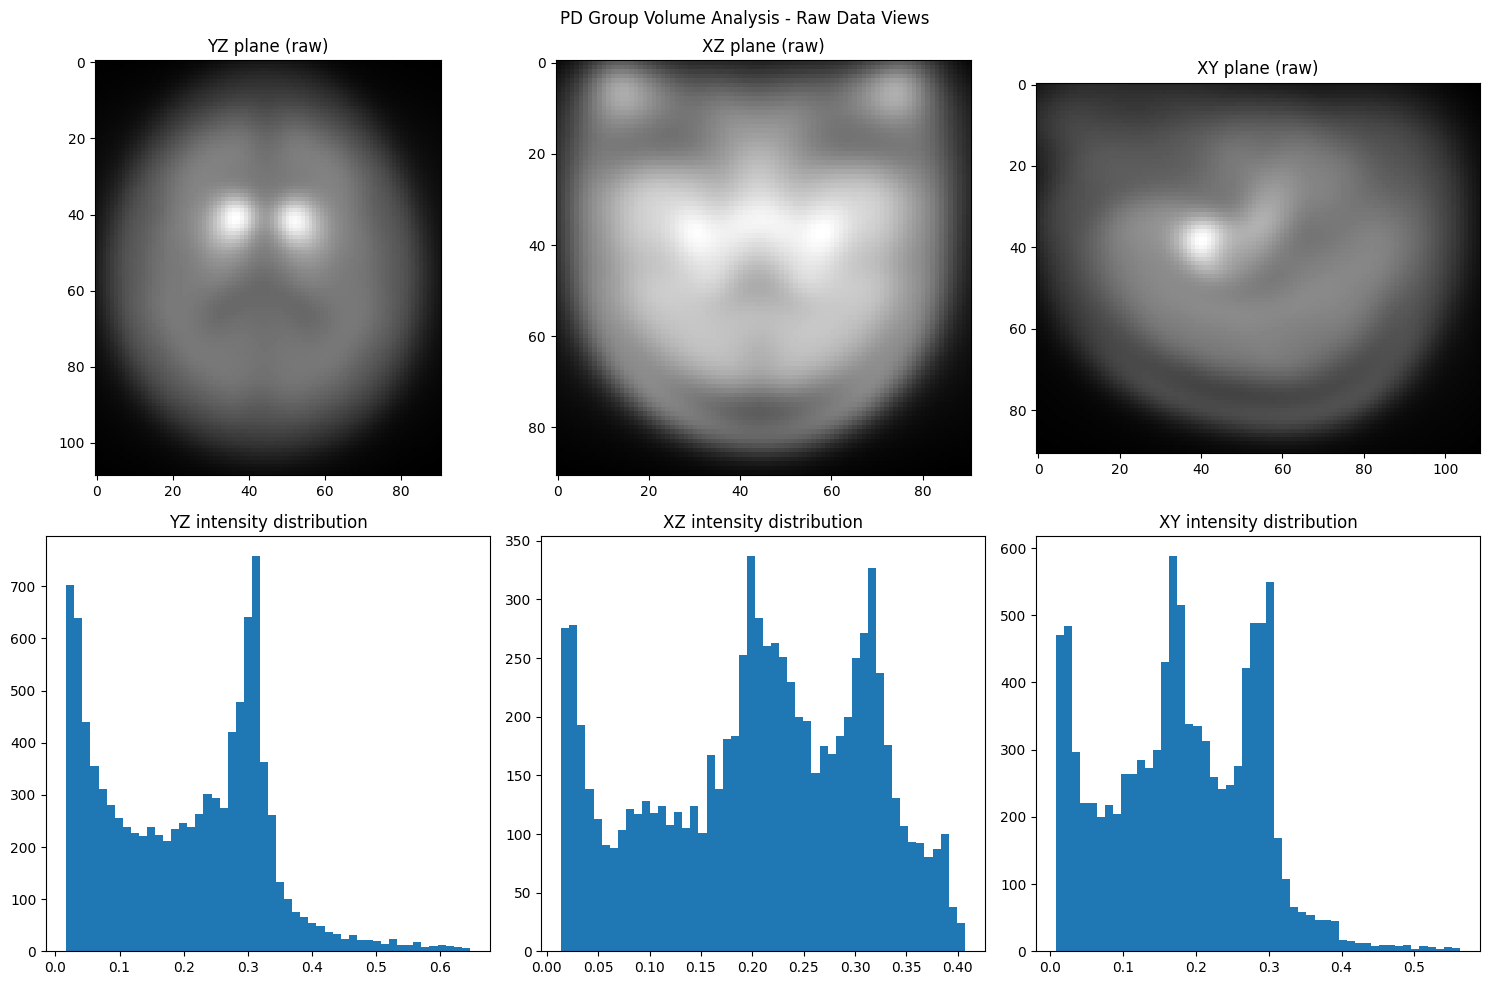


Statistics per plane:
YZ plane - min: 0.017, max: 0.647
XZ plane - min: 0.014, max: 0.407
XY plane - min: 0.008, max: 0.562

Debug visualization for SWEDD group:
Volume shape: (91, 109, 91)


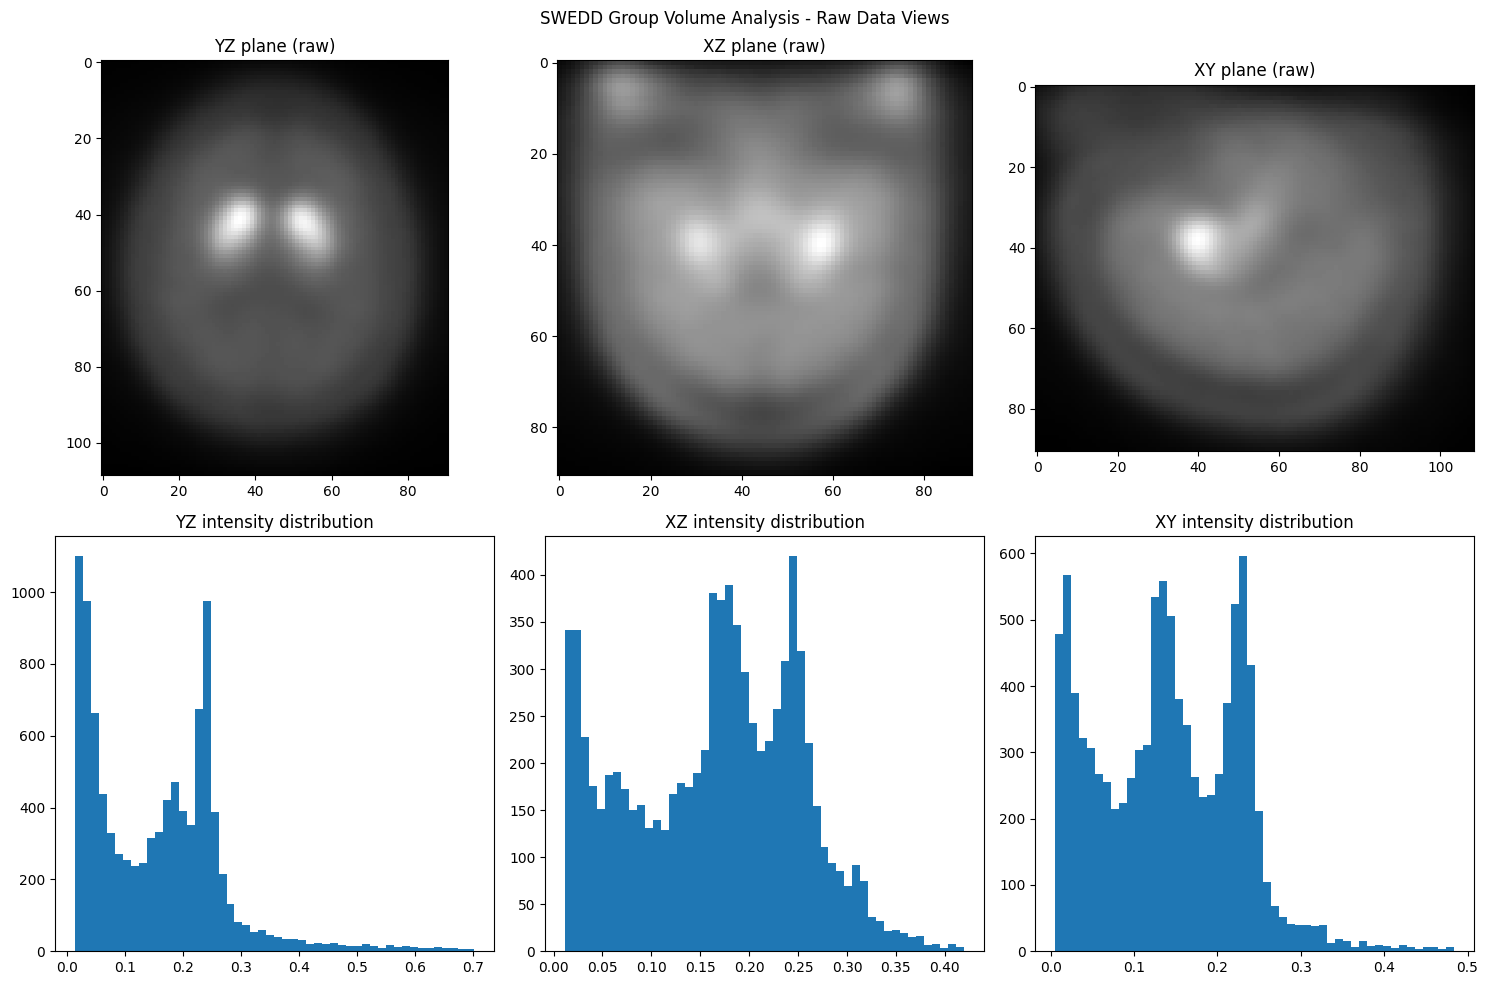


Statistics per plane:
YZ plane - min: 0.013, max: 0.702
XZ plane - min: 0.012, max: 0.420
XY plane - min: 0.005, max: 0.484

Debug visualization for Control group:
Volume shape: (91, 109, 91)


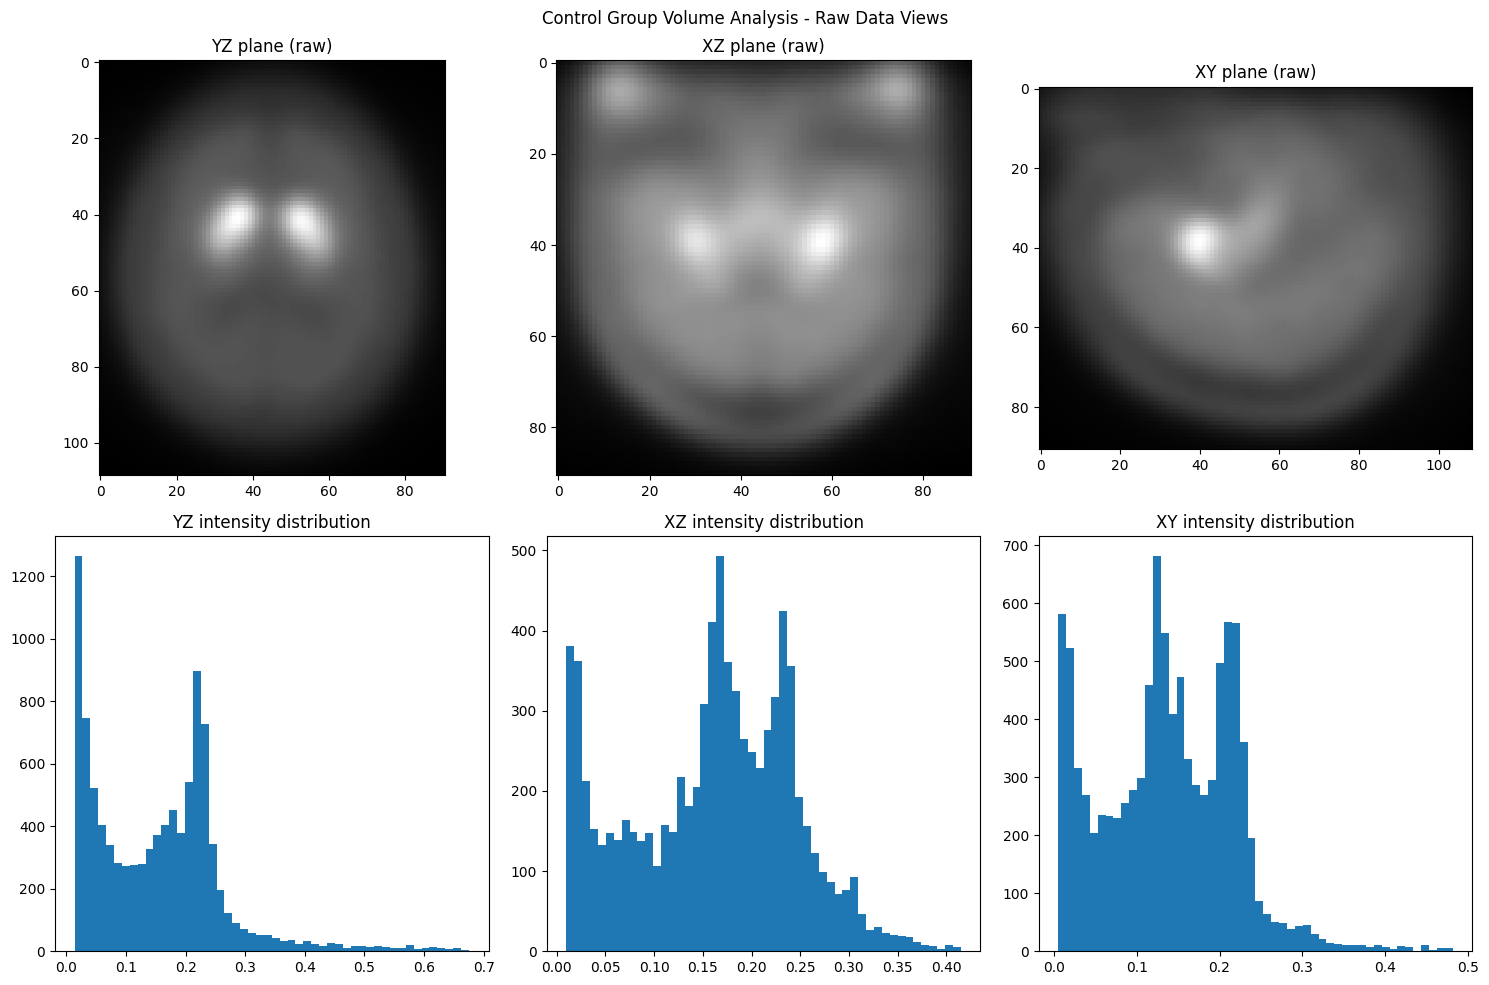


Statistics per plane:
YZ plane - min: 0.014, max: 0.675
XZ plane - min: 0.010, max: 0.415
XY plane - min: 0.005, max: 0.481


In [11]:
# Cell 10: Visualize the mean images and debug information
first_control_file = df[df['label'] == 'Control']['file_path'].iloc[0]
print("\nSingle DICOM control analysis:")
print_dicom_orientation(first_control_file)

# Debug information for each group
for label in ['PD', 'SWEDD', 'Control']:
    print(f"\nDebug visualization for {label} group:")
    debug_volume_visualization(mean_sums[label], title=f"{label} Group Volume Analysis")

In [12]:
# Cell 11: Visualize the mean images for each group with corrected orientation
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_views(mean_img, title_prefix):
    """
    Plots the axial, coronal, and sagittal views of the mean image with corrected orientation.
    Each image is rotated counterclockwise by 90 degrees.
    """
    # Swap axes if necessary to match anatomical planes
    # This rearranges the data from (Z, Y, X) to (X, Y, Z)
    mean_img = np.swapaxes(mean_img, 0, 2)

    # Compute the middle slices
    axial_slice = mean_img[:, :, mean_img.shape[2] // 2]
    coronal_slice = mean_img[:, mean_img.shape[1] // 2, :]
    sagittal_slice = mean_img[mean_img.shape[0] // 2, :, :]

    # Adjust the orientation of slices
    # First, flip slices to correct the orientation
    axial_slice = np.flipud(axial_slice)
    coronal_slice = np.flipud(coronal_slice)
    sagittal_slice = np.flipud(sagittal_slice)

    # Then, rotate each slice counterclockwise by 90 degrees
    axial_slice = np.rot90(axial_slice, k=1)
    coronal_slice = np.rot90(coronal_slice, k=1)
    sagittal_slice = np.rot90(sagittal_slice, k=1)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(f"{title_prefix} Mean Views")

    axes[0].imshow(axial_slice, cmap='gray', origin='upper')
    axes[0].set_title('Axial View')
    axes[0].axis('off')

    axes[1].imshow(coronal_slice, cmap='gray', origin='upper')
    axes[1].set_title('Coronal View')
    axes[1].axis('off')

    axes[2].imshow(sagittal_slice, cmap='gray', origin='upper')
    axes[2].set_title('Sagittal View')
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


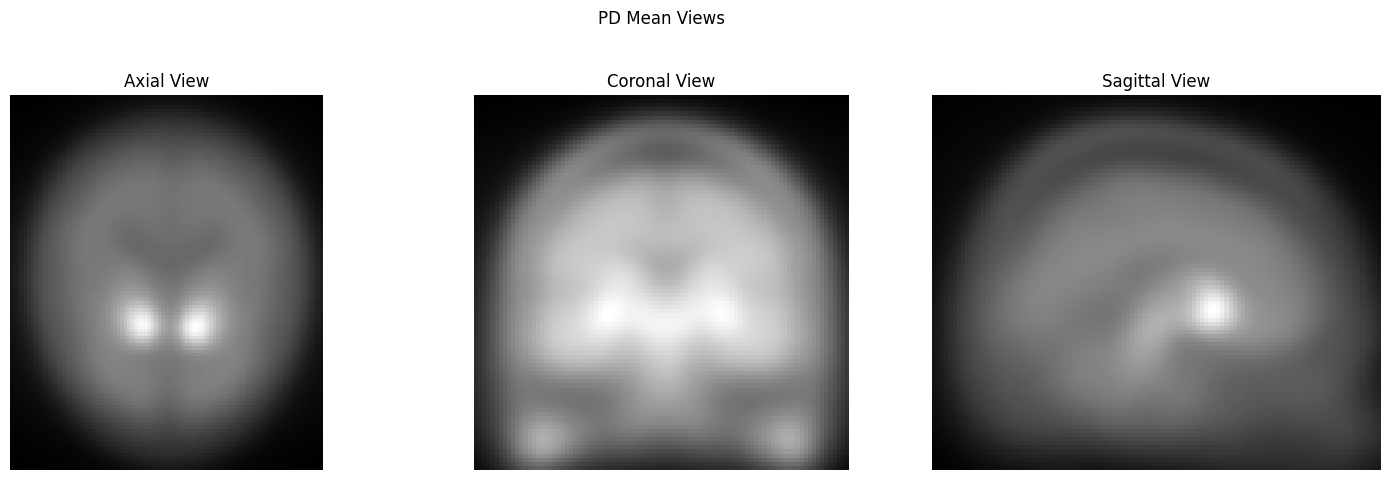

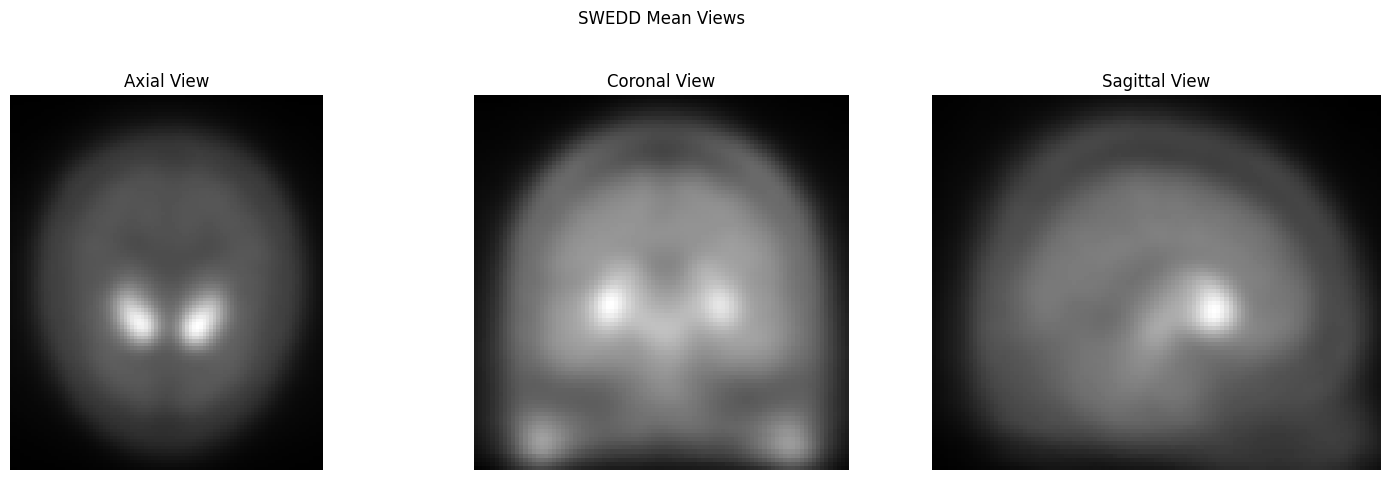

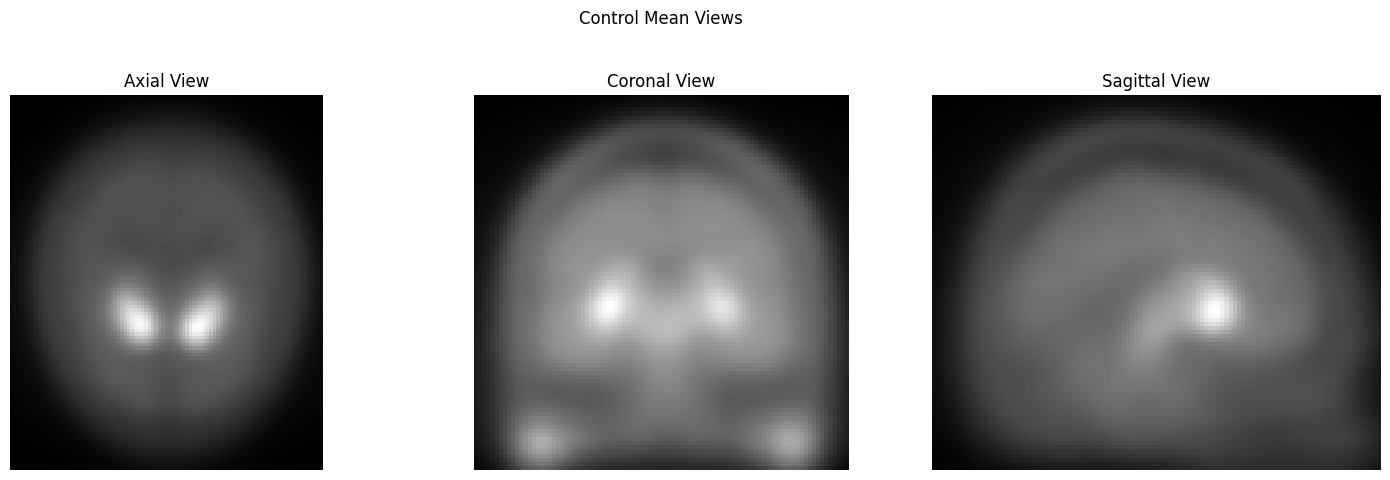

In [13]:
# Cell 12: Plot the mean views for each group
for label in group_labels.values():
    mean_img = mean_sums[label]
    plot_mean_views(mean_img, title_prefix=label)


Selected Random Patients:
PD: Patient ID 100639
SWEDD: Patient ID 3283
Control: Patient ID 3813
Visualizing Patient ID 100639 - File: Images\PPMI_Images_PD\100639\Reconstructed_DaTSCAN\2021-01-06_13_12_55.0\I1474776\PPMI_100639_NM_Reconstructed_DaTSCAN_Br_20210728202238881_1_S1048790_I1474776.dcm


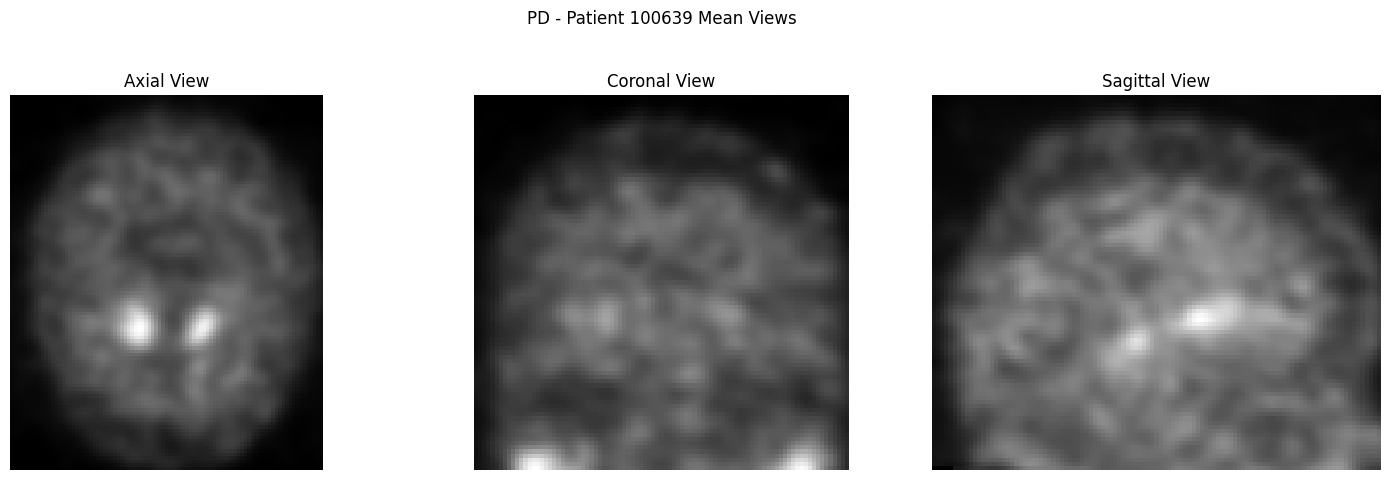

Visualizing Patient ID 3283 - File: Images\PPMI_Images_SWEDD\3283\Reconstructed_DaTSCAN\2012-06-27_19_12_10.0\I388492\PPMI_3283_NM_Reconstructed_DaTSCAN_Br_20130909134713720_1_S187788_I388492.dcm


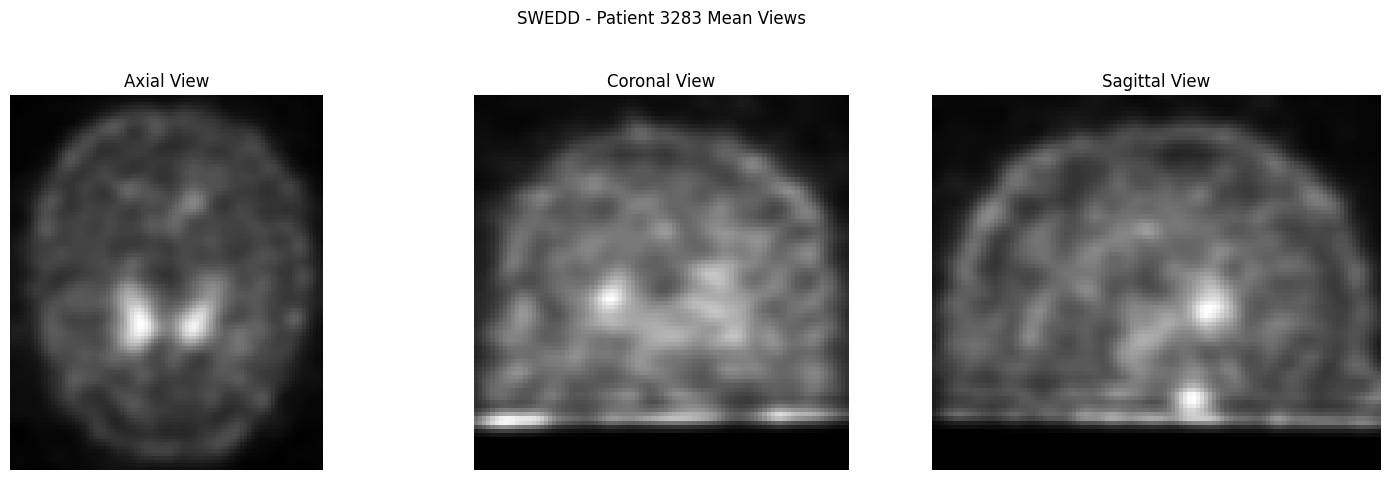

Visualizing Patient ID 3813 - File: Images\PPMI_Images_Cont\3813\Reconstructed_DaTSCAN\2012-10-16_13_13_47.0\I355233\PPMI_3813_NM_Reconstructed_DaTSCAN_Br_20130116130313605_1_S175497_I355233.dcm


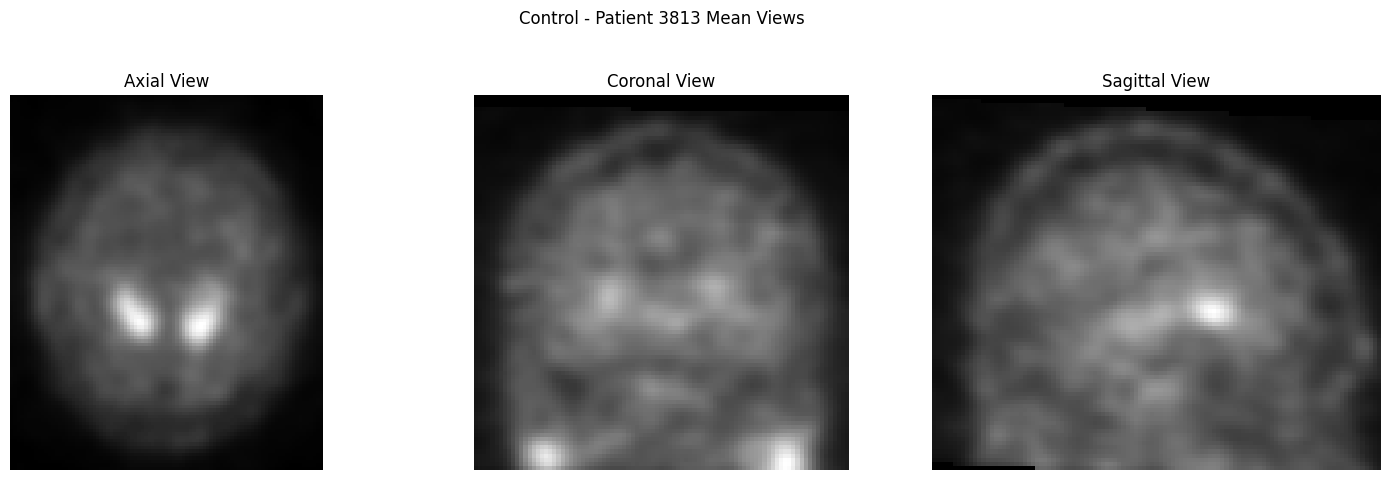

In [14]:
# Cell 13: Select and visualize a random patient from each group

import random

# Function to select a random patient from each group
def select_random_patients(df, groups):
    random_patients = {}
    for group in groups:
        group_df = df[df['label'] == group]
        unique_patients = group_df['patient_id'].unique()
        if len(unique_patients) == 0:
            print(f"No patients found in group: {group}")
            continue
        selected_patient = random.choice(unique_patients)
        random_patients[group] = selected_patient
    return random_patients

# Define the groups
groups = ['PD', 'SWEDD', 'Control']

# Select random patients
random_patients = select_random_patients(df, groups)
print("Selected Random Patients:")
for group, patient in random_patients.items():
    print(f"{group}: Patient ID {patient}")

    # Function to visualize a random image for a given patient
def visualize_random_patient(df, patient_id, label):
    """
    Select a random DICOM file for the given patient and plot its views.
    """
    patient_df = df[(df['patient_id'] == patient_id) & (df['label'] == label)]
    if patient_df.empty:
        print(f"No images found for Patient ID {patient_id} in group {label}.")
        return
    
    # Select a random image
    random_file = random.choice(patient_df['file_path'].tolist())
    print(f"Visualizing Patient ID {patient_id} - File: {random_file}")
    
    # Load the image
    img = load_dicom_image(random_file)
    
    # Plot the views
    plot_mean_views(img, title_prefix=f"{label} - Patient {patient_id}")

# Iterate over each group and visualize a random patient
for group, patient_id in random_patients.items():
    visualize_random_patient(df, patient_id, group)

## EDA

In [15]:
# Cell 14: Configure GPU settings and memory monitoring
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def get_memory_usage():
    """
    Get current memory usage of the system and GPU if available
    """
    # System memory
    process = psutil.Process()
    system_memory = process.memory_info().rss / 1024 / 1024  # MB
    
    # GPU memory
    gpu_memory = None
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.memory_allocated() / 1024 / 1024  # MB
    
    return system_memory, gpu_memory

if torch.cuda.is_available():
    # Print GPU info
    print(f"GPU Name: {torch.cuda.get_device_name()}")
    print(f"GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Set memory management options
    torch.cuda.empty_cache()
    torch.backends.cudnn.benchmark = True

Using device: cuda
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU
GPU Memory Available: 6.44 GB


In [16]:
# Cell 15: Enhanced image statistics computation with memory tracking
def compute_image_statistics(img):
    """
    Compute comprehensive statistics for a 3D image
    """
    stats_dict = {
        'mean': float(np.mean(img)),  # Convert to native Python types
        'std': float(np.std(img)),
        'min': float(np.min(img)),
        'max': float(np.max(img)),
        'median': float(np.median(img)),
        'skewness': float(stats.skew(img.flatten())),
        'kurtosis': float(stats.kurtosis(img.flatten())),
        'num_zeros': int(np.sum(img == 0)),
        'num_non_zeros': int(np.sum(img != 0)),
        'volume': int(img.size),
        'dimensions': img.shape
    }
    
    # Compute histogram data
    hist, bins = np.histogram(img.flatten(), bins=50)
    stats_dict['histogram'] = {
        'counts': hist.tolist(),  # Convert to list for better memory management
        'bins': bins.tolist()
    }
    
    return stats_dict

In [17]:
# Cell 16: Batch process images with improved memory management
def process_group_statistics(group_df, batch_size=5):
    """
    Process images in batches with memory monitoring
    """
    statistics = []
    
    # Create progress bar for the entire dataset
    with tqdm(total=len(group_df), desc="Processing images") as pbar:
        for start_idx in range(0, len(group_df), batch_size):
            end_idx = min(start_idx + batch_size, len(group_df))
            batch_df = group_df.iloc[start_idx:end_idx]
            
            for _, row in batch_df.iterrows():
                try:
                    img = load_dicom_image(row['file_path'])
                    stats = compute_image_statistics(img)
                    stats['patient_id'] = row['patient_id']
                    statistics.append(stats)
                    del img
                except Exception as e:
                    tqdm.write(f"Error processing {row['file_path']}: {e}")
                
                pbar.update(1)
            
            # Clean up memory after batch
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    return statistics

In [18]:
# Cell 17: Process statistics for each group with progress tracking
group_statistics = {}
group_labels = {'PD': 'PD', 'SWEDD': 'SWEDD', 'Control': 'Control'}  # Move this here for clarity

for label in group_labels.values():
    print(f"\nProcessing statistics for {label} group...")
    start_time = time.time()
    
    group_df = df[df['label'] == label]
    group_statistics[label] = process_group_statistics(group_df)
    
    duration = time.time() - start_time
    print(f"Completed {label} group in {duration:.2f} seconds")
    print(f"Processed {len(group_statistics[label])} images")


Processing statistics for PD group...


Processing images: 100%|██████████| 2555/2555 [03:26<00:00, 12.39it/s]


Completed PD group in 206.28 seconds
Processed 2555 images

Processing statistics for SWEDD group...


Processing images: 100%|██████████| 137/137 [00:11<00:00, 12.23it/s]


Completed SWEDD group in 11.20 seconds
Processed 137 images

Processing statistics for Control group...


Processing images: 100%|██████████| 294/294 [00:24<00:00, 11.98it/s]

Completed Control group in 24.54 seconds
Processed 294 images


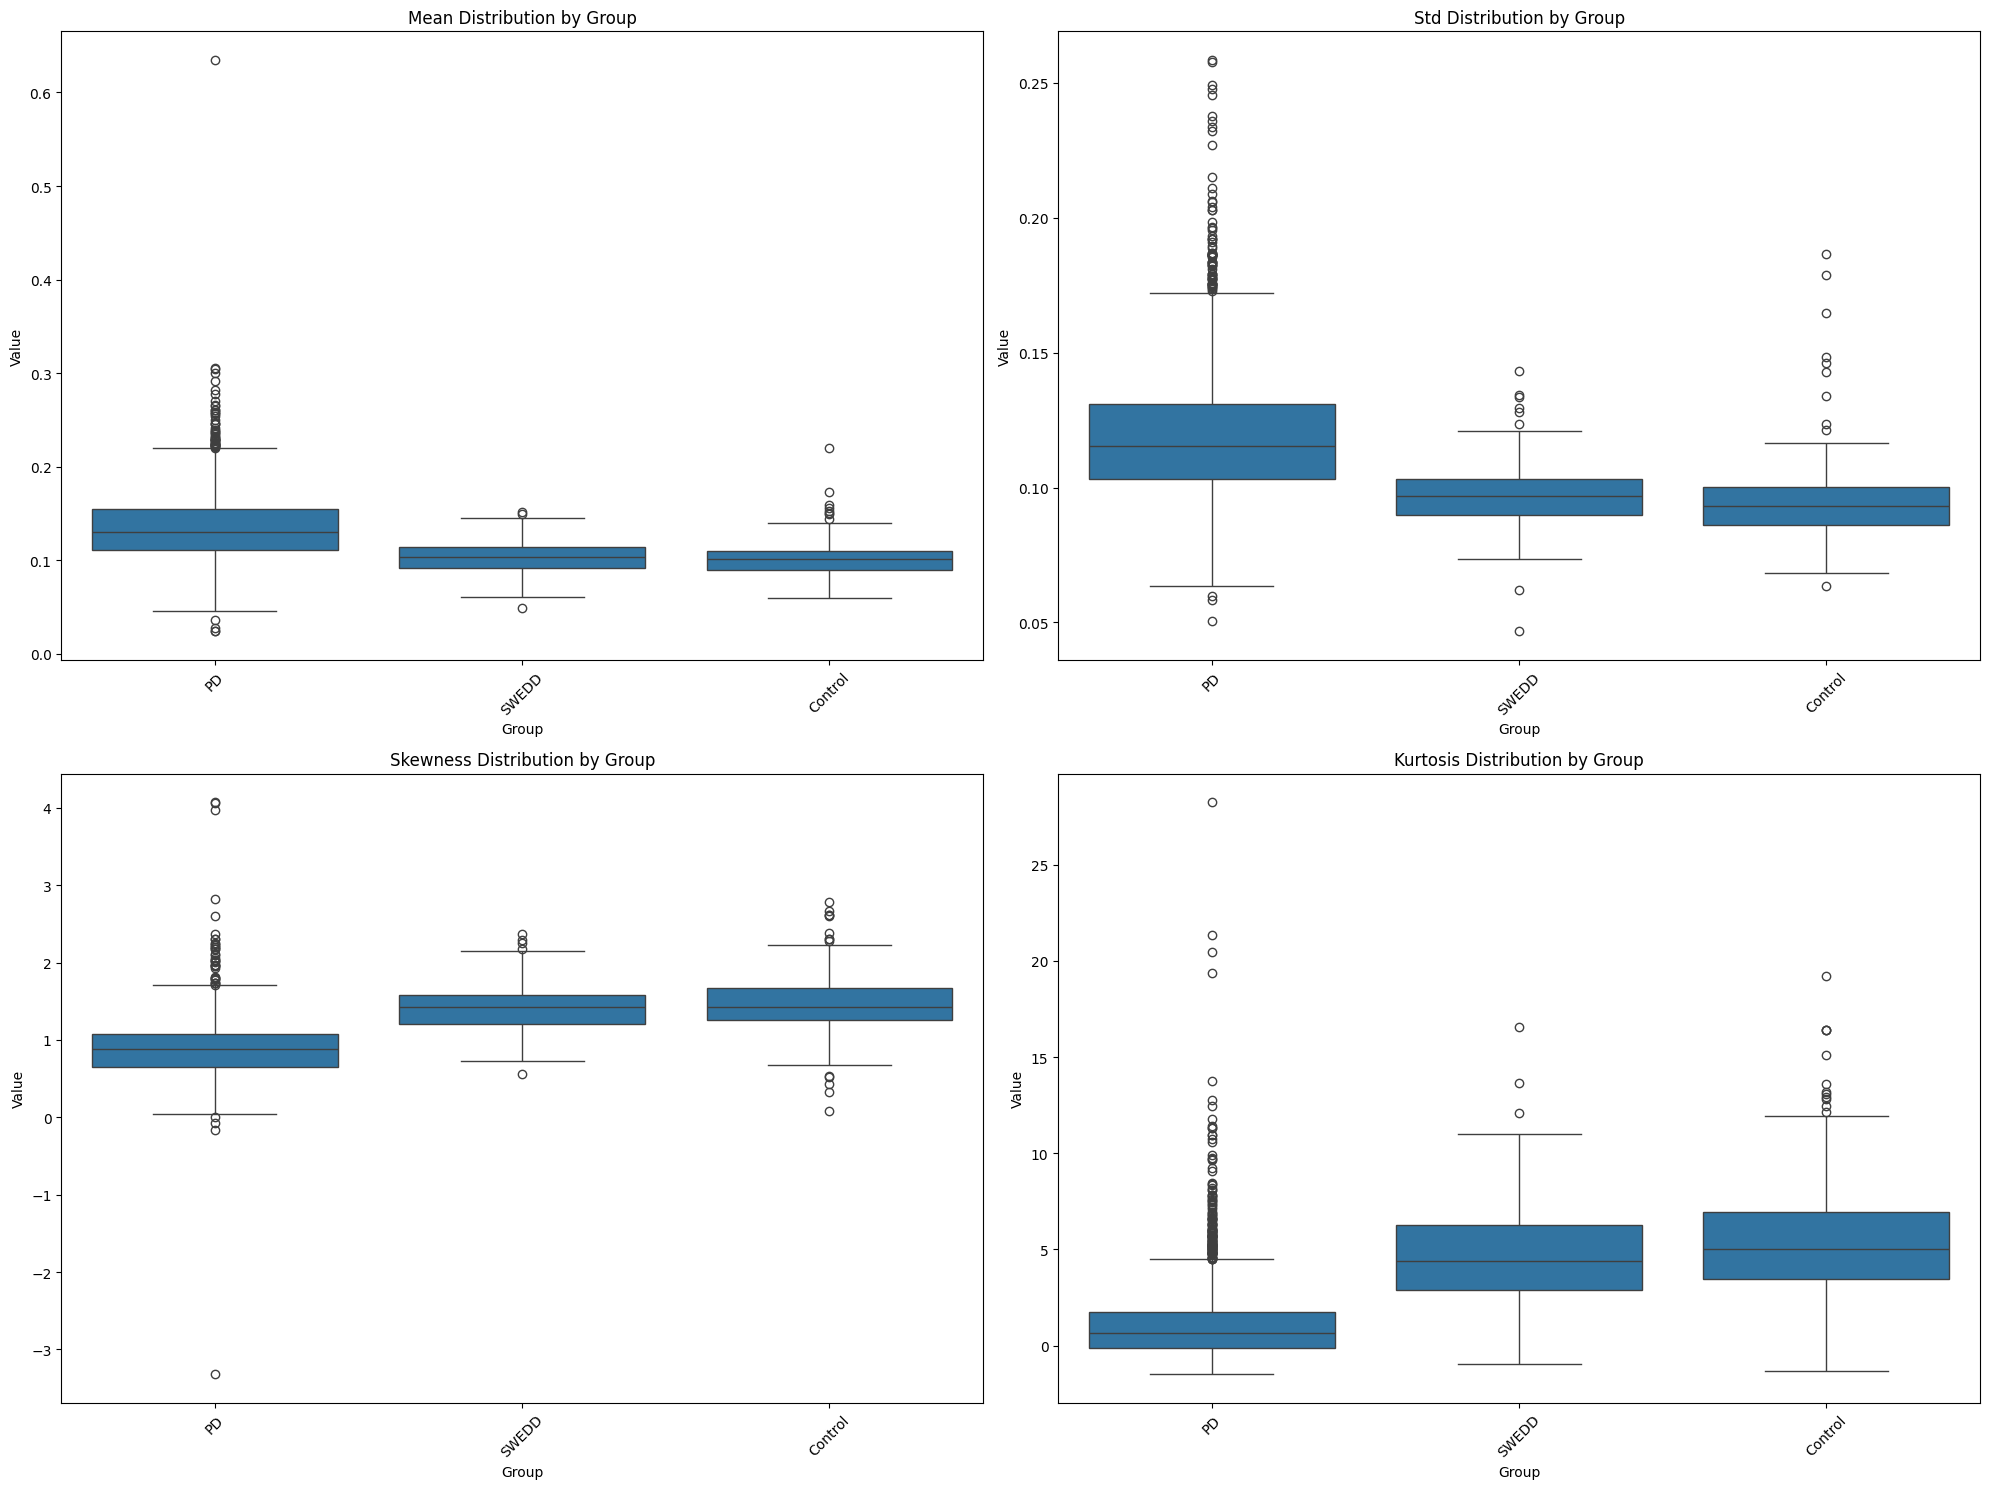

In [19]:
# Cell 18: Visualize statistical distributions with efficient memory usage
def plot_group_statistics(group_statistics):
    """
    Create comparison plots for different statistical measures across groups
    """
    import seaborn as sns  # Add this import if not already present
    
    metrics = ['mean', 'std', 'skewness', 'kurtosis']
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    for idx, (metric, ax) in enumerate(zip(metrics, axes.flatten())):
        plot_data = []
        group_names = []
        
        # Directly use the groups from group_statistics dictionary
        for group in group_statistics.keys():
            values = [s[metric] for s in group_statistics[group]]
            plot_data.extend(values)
            group_names.extend([group] * len(values))
        
        # Create DataFrame for seaborn
        df_plot = pd.DataFrame({
            'Group': group_names,
            'Value': plot_data
        })
        
        # Create boxplot
        sns.boxplot(data=df_plot, x='Group', y='Value', ax=ax)
        ax.set_title(f'{metric.capitalize()} Distribution by Group')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Clean up
    plt.close('all')
    gc.collect()

# Now plot the statistics
plot_group_statistics(group_statistics)

### Intensity distributions analysis by Group

**Mean Distribution by Group**

The average intensity values of voxels in the brain scans for each group (PD, SWEDD, Control).

- **Higher means** indicate brighter regions overall in the scan.
  - In DAT scans, this is particularly important because dopamine transporters show up as bright areas.
  - **Lower mean values** in PD patients often indicate loss of dopamine transporters.
  - SWEDD patients (Scans Without Evidence of Dopaminergic Deficit) should show values more similar to controls.
- The box shows where **50% of data** falls, with the middle line being the **median**.
- Whiskers show the range of "normal" values, and dots are **outliers**.

**Standard Deviation (Std) Distribution by Group**

How much variation or dispersion exists in the voxel intensities.

- **Higher std** means more contrast between different regions in the brain.
- **Lower std** suggests more uniform intensity across the scan.
- In PD patients:
  - Lower std may reflect loss of the normally bright dopamine transporter regions.
- **Controls** should show higher std due to clear distinction between regions with and without dopamine transporters.
- **SWEDD patients** should be similar to controls in this measure.

**Skewness Distribution by Group**

The asymmetry of the intensity distribution.

- **Positive skewness** (value > 0) means there's a long tail of high values.
- **Negative skewness** (value < 0) means there's a long tail of low values.
- In DAT scans:
  - **Controls** often show positive skewness due to the presence of bright dopamine transporter regions.
  - **PD patients** might show less positive skewness due to loss of these bright regions.
  - **SWEDD** should be similar to controls.
- This measure can help identify patterns in how the disease affects certain brain regions.

**Kurtosis Distribution by Group**

The "tailedness" of the intensity distribution.

- **Higher kurtosis** means more extreme values (outliers).
- **Lower kurtosis** means the data is more uniformly distributed.
- In DAT scans:
  - **Controls** might show higher kurtosis due to the distinct contrast between regions.
  - **PD patients** might show lower kurtosis due to more uniform (and reduced) signal.
  - **SWEDD patients** should again be more similar to controls.
- This can help identify how distinct the dopamine transporter regions are from background tissue.

In [20]:
# Cell 20: Analyze spatial characteristics with memory optimization
def compute_spatial_features(img):
    """
    Analyze spatial characteristics of 3D images with memory optimization
    """
    # Compute gradients one at a time to save memory
    gradients = []
    for axis in range(3):
        grad = np.gradient(img, axis=axis)
        gradients.append(grad)
        
    gradient_magnitude = np.sqrt(sum(grad**2 for grad in gradients))
    del gradients  # Free memory
    
    # Compute edge information using Sobel
    from scipy import ndimage
    edges = []
    for axis in range(3):
        edge = ndimage.sobel(img, axis=axis)
        edges.append(edge**2)
    
    edge_magnitude = np.sqrt(sum(edges))
    del edges  # Free memory
    
    # Compute statistics
    spatial_stats = {
        'gradient_stats': compute_image_statistics(gradient_magnitude),
        'edge_stats': compute_image_statistics(edge_magnitude)
    }
    
    # Clean up
    del gradient_magnitude, edge_magnitude
    gc.collect()
    
    return spatial_stats

In [21]:
# Cell 21: Analyze ROI characteristics with memory efficiency
def analyze_roi_characteristics(img, threshold=0.5):
    """
    Analyze characteristics of regions of interest with memory optimization
    """
    # Create binary mask
    binary_mask = img > threshold
    del img  # Free original image memory if not needed
    
    # Label connected components
    labeled_array, num_features = ndimage.label(binary_mask)
    del binary_mask  # Free binary mask memory
    
    roi_properties = {
        'num_regions': num_features,
        'volumes': [],
        'centroids': [],
        'mean_intensities': []
    }
    
    # Process each ROI
    for label in range(1, num_features + 1):
        region_mask = labeled_array == label
        roi_properties['volumes'].append(int(np.sum(region_mask)))
        roi_properties['centroids'].append(tuple(map(float, ndimage.center_of_mass(region_mask))))
        roi_properties['mean_intensities'].append(float(np.mean(img[region_mask])))
        del region_mask  # Free mask memory after each iteration
    
    del labeled_array  # Free labeled array memory
    gc.collect()
    
    return roi_properties

In [22]:
# Cell 22: Visualize ROI distribution with batch processing
def plot_roi_distributions(group_statistics):
    plt.figure(figsize=(15, 5))
    
    for idx, (group, stats) in enumerate(group_statistics.items()):
        roi_volumes = []
        
        # Process in smaller batches
        batch_size = 10
        for i in range(0, len(stats), batch_size):
            batch_stats = stats[i:i + batch_size]
            
            for stat in batch_stats:
                img = load_dicom_image(df[df['patient_id'] == stat['patient_id']].iloc[0]['file_path'])
                roi_props = analyze_roi_characteristics(img)
                roi_volumes.extend(roi_props['volumes'])
                del img, roi_props
                gc.collect()
        
        plt.subplot(1, 3, idx+1)
        sns.histplot(roi_volumes, bins=30)
        plt.title(f'ROI Volume Distribution - {group}')
        plt.xlabel('Volume (voxels)')
        plt.ylabel('Count')
        
        del roi_volumes
        gc.collect()
    
    plt.tight_layout()
    plt.show()
    plt.close('all')

In [23]:
# Cell 23: Save processed statistics with compression
import pickle
import gzip

# Save statistics to compressed file for better storage
with gzip.open('group_statistics.pkl.gz', 'wb') as f:
    pickle.dump(group_statistics, f)

In [24]:
# Cell 24: Print summary report
print("\nEDA Summary Report")
print("-----------------")
for group, stats in group_statistics.items():
    print(f"\n{group} Group:")
    print(f"Number of samples: {len(stats)}")
    
    # Calculate aggregate statistics
    means = np.mean([s['mean'] for s in stats])
    stds = np.mean([s['std'] for s in stats])
    skew = np.mean([s['skewness'] for s in stats])
    kurt = np.mean([s['kurtosis'] for s in stats])
    
    print(f"Average intensity: {means:.2f} ± {stds:.2f}")
    print(f"Average skewness: {skew:.2f}")
    print(f"Average kurtosis: {kurt:.2f}")


EDA Summary Report
-----------------

PD Group:
Number of samples: 2555
Average intensity: 0.13 ± 0.12
Average skewness: 0.88
Average kurtosis: 1.11

SWEDD Group:
Number of samples: 137
Average intensity: 0.10 ± 0.10
Average skewness: 1.42
Average kurtosis: 4.73

Control Group:
Number of samples: 294
Average intensity: 0.10 ± 0.09
Average skewness: 1.49
Average kurtosis: 5.57


### EDA Overview Report

**Dataset Composition**
The analysis encompasses a total of 2,986 DATSCAN images distributed across three groups:
- Parkinson's Disease (PD): 2,555 samples (85.6%)
- SWEDD: 137 samples (4.6%)
- Control: 294 samples (9.8%)

It's worth noting that there is a significant class imbalance in the dataset, with PD cases representing the vast majority of the samples. This imbalance should be considered during model development and validation phases.

**Intensity Analysis**

***Average Intensities (μ ± σ)***
- PD Group: 0.13 ± 0.12
- SWEDD Group: 0.10 ± 0.10
- Control Group: 0.10 ± 0.09

The intensity patterns reveal several interesting findings:
1. PD patients show slightly higher average intensity (0.13) compared to other groups, which is somewhat counterintuitive as we would typically expect lower dopamine transporter activity in PD patients. This might suggest:
   - Potential compensation mechanisms in the brain
   - Variations in image acquisition or normalization
   - The need for region-specific analysis rather than global intensity measurements

2. SWEDD and Control cases show identical average intensities (0.10), which:
   - Aligns with the clinical presentation of SWEDD cases showing no evidence of dopaminergic deficit
   - Suggests that simple intensity measures alone may not be sufficient to distinguish between these groups
   - Indicates the need for more sophisticated analysis methods

**Distribution Characteristics:**

***Skewness Analysis***
- PD Group: 0.88
- SWEDD Group: 1.42
- Control Group: 1.49

The skewness values offer valuable insights:
1. All groups show positive skewness, indicating right-tailed distributions (more low-intensity values with a tail toward higher intensities)
2. SWEDD and Control groups show notably higher skewness (1.42 and 1.49 respectively) compared to PD (0.88)
3. This pattern suggests:
   - More uniform intensity distribution in PD cases, possibly due to loss of contrast in dopamine transporter regions
   - Similar intensity patterns between SWEDD and Control groups, supporting their clinical similarity
   - Potential biomarker patterns in the intensity distribution shape

***Kurtosis Analysis***
- PD Group: 1.11
- SWEDD Group: 4.73
- Control Group: 5.57

The kurtosis values reveal striking differences:
1. PD cases show markedly lower kurtosis (1.11) compared to both other groups
2. Control group shows the highest kurtosis (5.57), followed closely by SWEDD cases (4.73)
3. These patterns indicate:
   - More uniform intensity distribution in PD cases (closer to mesokurtic)
   - More extreme values in both SWEDD and Control cases (highly leptokurtic)
   - Potential loss of distinct dopamine transporter regions in PD cases

**Clinical Implications**
These statistical findings have several important implications for clinical practice and research:

1. *Diagnostic Potential*:
   - The distinct kurtosis values between PD and non-PD cases suggest potential diagnostic value
   - The similarity in intensity and distribution patterns between SWEDD and Control cases explains the challenge in clinical differentiation

2. *Group Characteristics*:
   - PD cases show more uniform intensity distributions (lower skewness and kurtosis)
   - SWEDD and Control cases show more varied distributions with more extreme values
   - The slight intensity difference in PD cases might represent a compensatory mechanism

3. *Future Directions*:
   - Region-specific analysis might reveal more detailed patterns
   - Machine learning models should consider these distribution characteristics
   - The class imbalance should be addressed in model development
   - Investigation of the biological basis for the intensity patterns in PD cases

# Preprocessing

In [43]:
# Cell 25: Import dependencies
# Clear any previous imports to ensure we're using the latest versions
import importlib
import sys
if 'preprocessing' in sys.modules:
    del sys.modules['preprocessing']

# Import all necessary libraries first
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset
from scipy import ndimage
from skimage import filters
from skimage.transform import resize
import albumentations as A
from typing import Tuple, Optional, Dict
from pydicom import dcmread
import torch.utils.data

# Now import from preprocessing.py
from preprocessing import DATSCANPreprocessor, DATSCANDataset, create_dataloaders

In [32]:
# Cell 26: Create and test the preprocessing pipeline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

try:
    dataloaders = create_dataloaders(
        df=df,
        batch_size=8,  # Reduced batch size for testing
        target_shape=(128, 128, 128),
        normalize_method='minmax',
        apply_brain_mask=True,
        augment=False,
        device=torch.device('cpu'),  # Keep data on CPU initially
        num_workers=2  # Use 2 workers for testing
    )

    # Test the dataloaders
    for group, dataloader in dataloaders.items():
        print(f"\nTesting {group} dataloader:")
        print(f"Number of samples: {len(dataloader.dataset)}")
        batch = next(iter(dataloader))
        # Move batch to device after loading
        batch = batch.to(device)
        print(f"Batch shape: {batch.shape}")
        print(f"Batch tensor device: {batch.device}")
        print(f"Value range: [{batch.min():.3f}, {batch.max():.3f}]")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    import traceback
    traceback.print_exc()

Using device: cuda

Testing PD dataloader:
Number of samples: 2555
Batch shape: torch.Size([8, 1, 128, 128, 128])
Batch tensor device: cuda:0
Value range: [0.000, 0.995]

Testing SWEDD dataloader:
Number of samples: 137
Batch shape: torch.Size([8, 1, 128, 128, 128])
Batch tensor device: cuda:0
Value range: [0.000, 0.993]

Testing Control dataloader:
Number of samples: 294
Batch shape: torch.Size([8, 1, 128, 128, 128])
Batch tensor device: cuda:0
Value range: [0.000, 0.996]



Visualizing preprocessed PD samples:


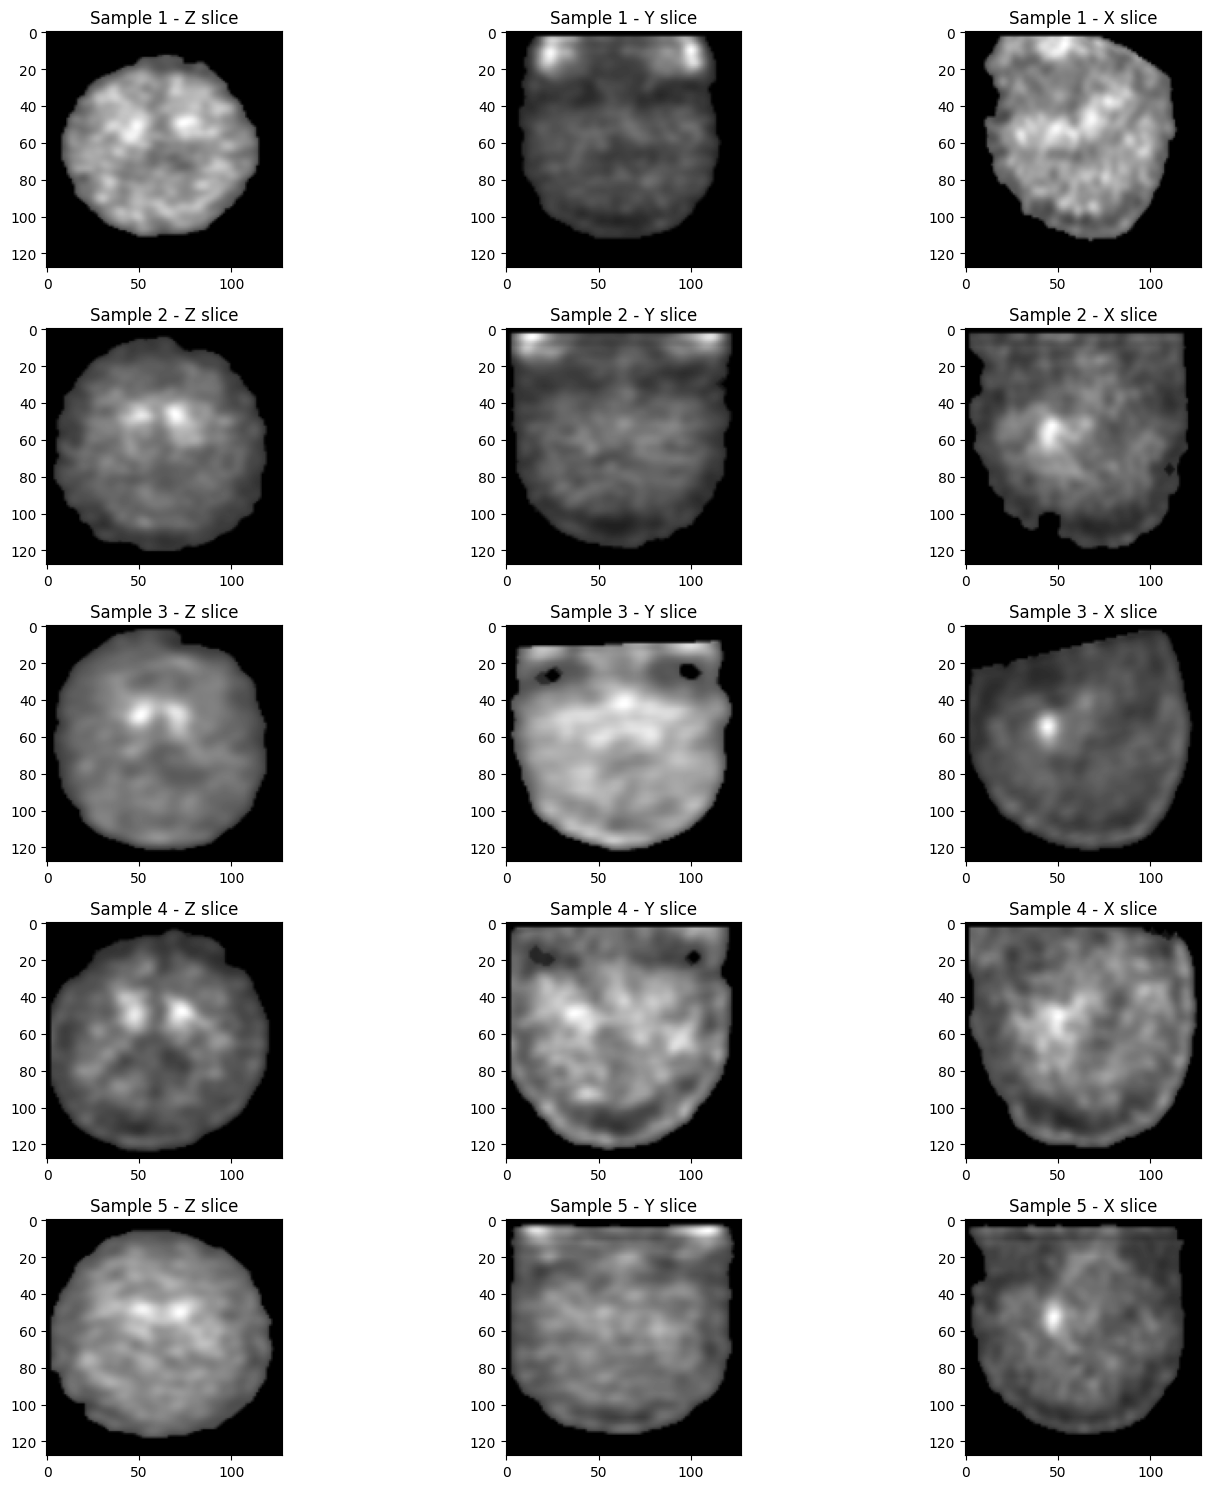


Visualizing preprocessed SWEDD samples:


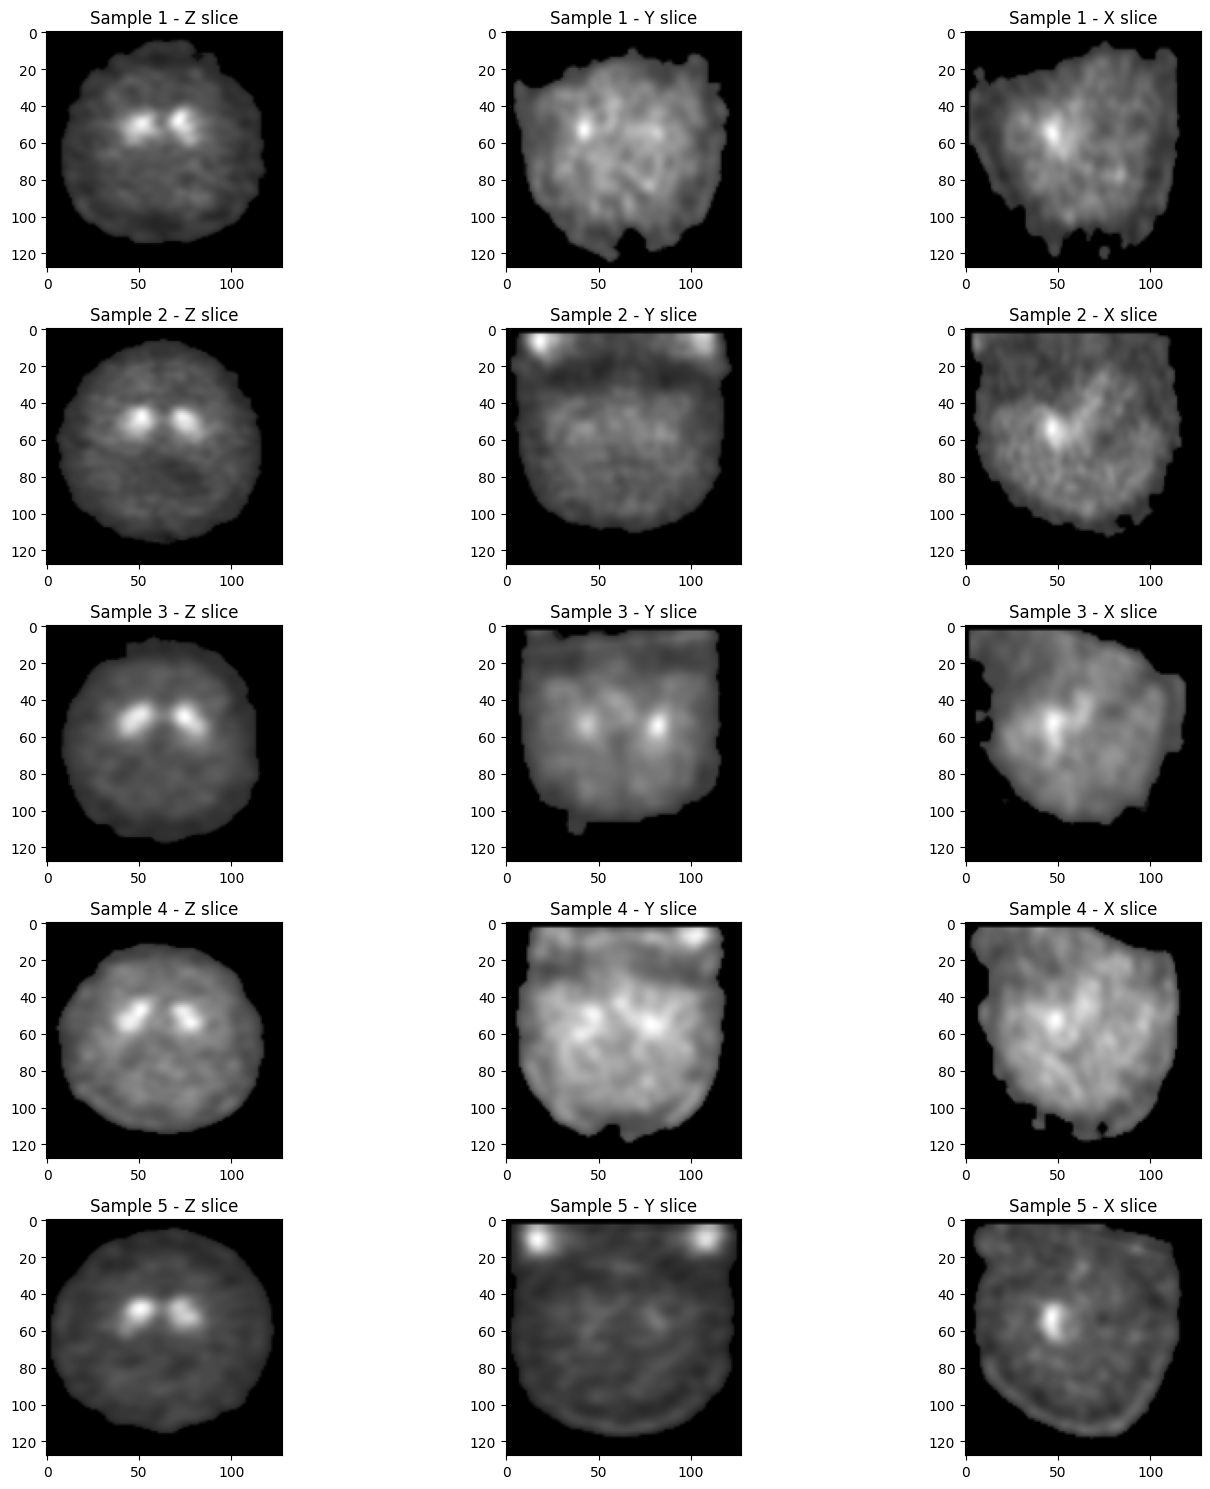


Visualizing preprocessed Control samples:


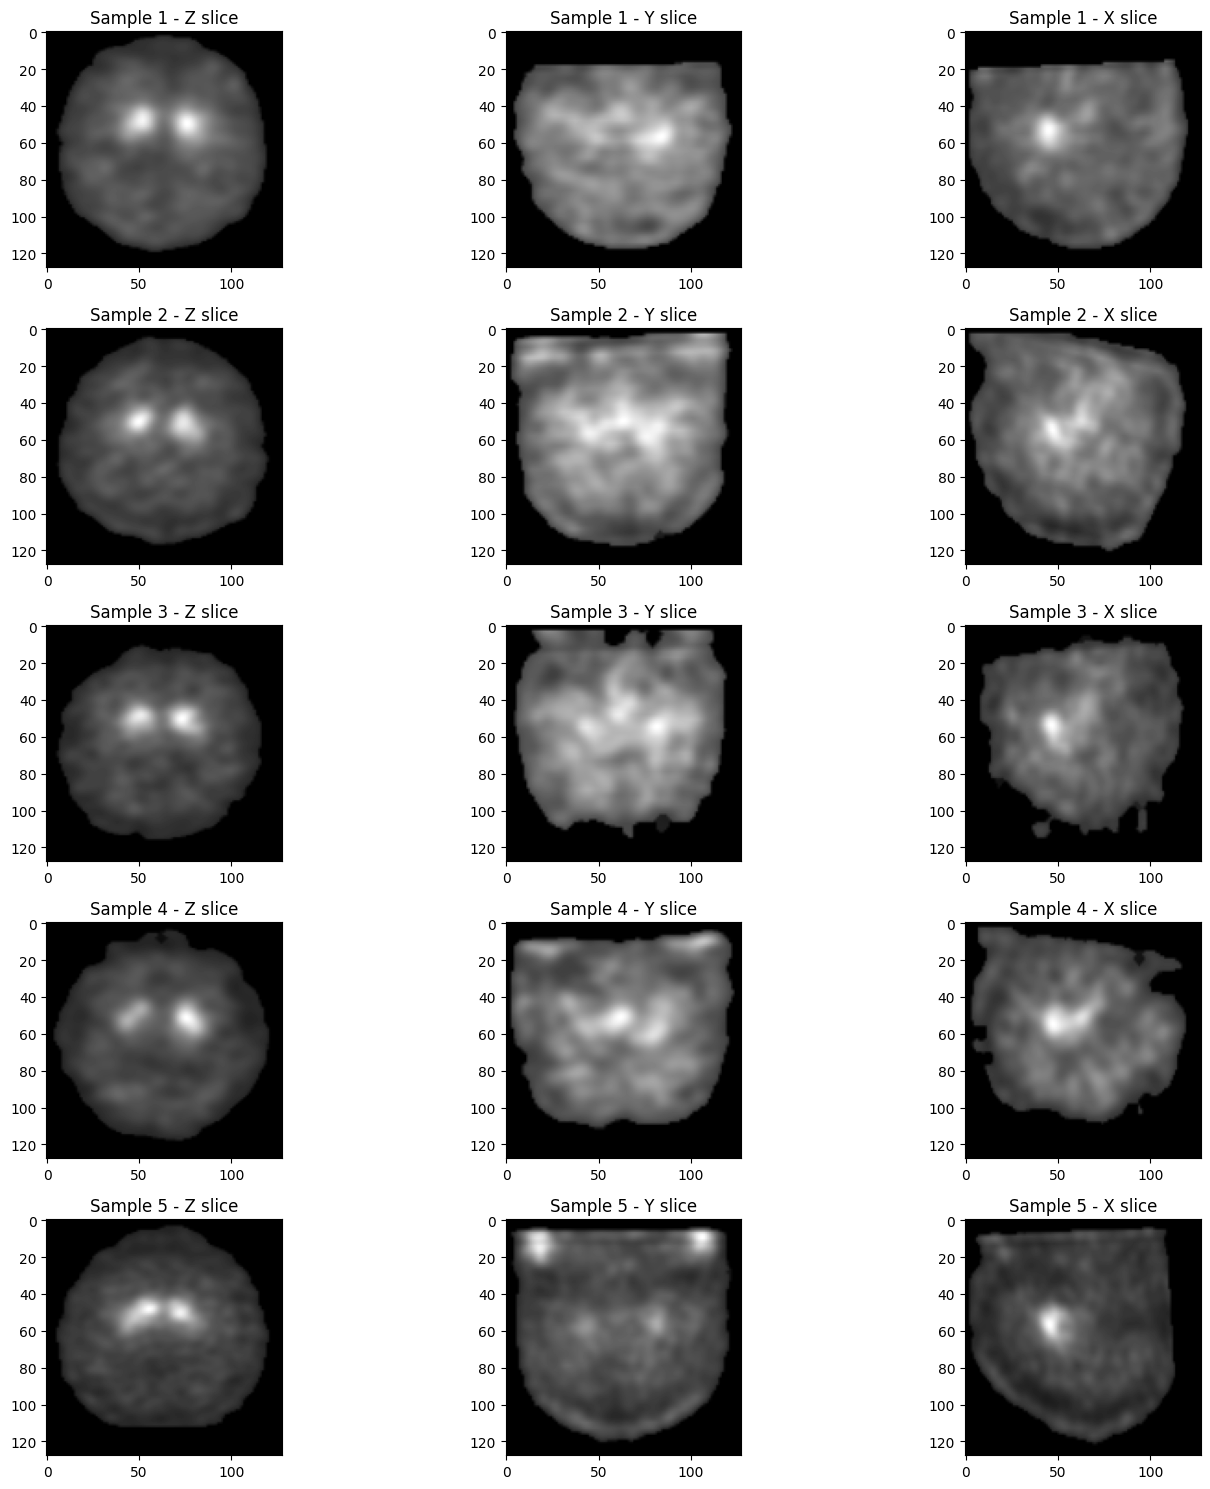

In [33]:
# Cell 27: Visualize the preprocessed images
def visualize_preprocessed_batch(batch, num_samples=5):
    """
    Visualize central slices of preprocessed 3D images.
    """
    batch = batch.cpu().numpy()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 3*num_samples))
    
    for i in range(min(num_samples, batch.shape[0])):
        # Get central slices
        z_slice = batch[i, 0, batch.shape[2]//2, :, :]
        y_slice = batch[i, 0, :, batch.shape[3]//2, :]
        x_slice = batch[i, 0, :, :, batch.shape[4]//2]
        
        axes[i, 0].imshow(z_slice, cmap='gray')
        axes[i, 0].set_title(f'Sample {i+1} - Z slice')
        axes[i, 1].imshow(y_slice, cmap='gray')
        axes[i, 1].set_title(f'Sample {i+1} - Y slice')
        axes[i, 2].imshow(x_slice, cmap='gray')
        axes[i, 2].set_title(f'Sample {i+1} - X slice')
    
    plt.tight_layout()
    plt.show()

# Visualize samples from each group
for group, dataloader in dataloaders.items():
    print(f"\nVisualizing preprocessed {group} samples:")
    batch = next(iter(dataloader))
    visualize_preprocessed_batch(batch)

### Preprocessing Analysis

**Overview of Current Preprocessing**

Our preprocessing pipeline has successfully transformed raw DATSCAN images into standardized 3D volumes suitable for deep learning analysis. Let's examine what each preprocessing step accomplishes and why it's important.

**Data Standardization**

The preprocessing pipeline implements several critical standardization steps:

1. *Intensity Normalization*: we normalize pixel intensities to a common scale (0-1) to ensure that images from different scanners or acquisition protocols are comparable. This is crucial because:
- Raw DICOM images can have varying intensity ranges
- Different scanners might use different calibrations
- Patient-specific factors can affect absolute intensity values

2. *Brain Masking*: the pipeline applies an automated brain mask using Otsu thresholding and morphological operations. This step:

- Removes non-brain tissue and background noise
- Focuses the analysis on relevant brain regions
- Reduces computational overhead by eliminating irrelevant areas
- Improves the signal-to-noise ratio for subsequent analysis

3. *Dimension Standardization (128x128x128)*: the choice of 128x128x128 dimensions represents a careful balance of several factors:

- Memory Efficiency: original DATSCAN images could come in various sizes. Processing full-size images would require significantly more GPU memory, and 128³ provides sufficient detail while being computationally manageable.
- Power of 2: 128 is a power of 2 (2⁷). This makes it optimal for many deep learning architectures, especially those using consecutive downsampling operations. For example, convolutional neural networks often perform better with dimensions that are powers of 2.

____________________________________________________

**Visualization Results**

***Axial View (Z-slice)***
- Clear visualization of the striatum
- Symmetrical presentation of dopamine transporter binding
- Effective contrast between regions of high and low uptake

***Coronal View (Y-slice)***
- Well-defined brain boundaries
- Clear differentiation of striatal regions
- Preserved anatomical relationships

***Sagittal View (X-slice)***
- Distinct anterior-posterior organization
- Visible striatal structures
- Maintained spatial relationships

_____________________________________


**Quality Assessment**

The preprocessing results show:
- Consistent intensity distributions across samples
- Clear anatomical boundaries
- Preserved striatal signal intensity
- Effective noise reduction
- Maintained biological relevance

# Modeling

In [44]:
# Cell 25A: Force reload preprocessing
import importlib
import preprocessing
importlib.reload(preprocessing)
from preprocessing import DATSCANPreprocessor, DATSCANDataset, create_dataloaders

# Cell 25B: Recreate dataloaders with smaller batch size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

dataloaders = create_dataloaders(
    df=df,
    batch_size=2,  # Smaller batch size
    target_shape=(128, 128, 128),
    normalize_method='minmax',
    apply_brain_mask=True,
    augment=False,
    device=torch.device('cpu'),  # Keep data on CPU initially
    num_workers=2
)

print("\nDataloaders created with the following sizes:")
for group, loader in dataloaders.items():
    print(f"{group}: {len(loader.dataset)} images")

Using device: cuda

Dataloaders created with the following sizes:
PD: 2555 images
SWEDD: 137 images
Control: 294 images


In [45]:
# Cell 29: Import and initialize the VAE model

# Force reload of the modules
import importlib
import vae_model
import vae_training
importlib.reload(vae_model)
importlib.reload(vae_training)

from vae_model import DATScanVAE
from vae_training import train_vae

# Initialize model with reduced memory footprint
latent_dim = 32  # Reduced from 64
model = DATScanVAE(latent_dim=latent_dim).to(device)

# Create a combined dataloader with smaller batch size
batch_size = 2  # Reduced batch size for memory efficiency
print("Starting training...")
history = train_vae(
    model=model,
    train_loader=dataloaders['PD'],
    num_epochs=5,
    learning_rate=1e-4,
    device=device,
    save_path='datscan_vae.pt'
)
print("Training completed!")

Starting training...

Epoch 1/5


Training: 100%|██████████| 1278/1278 [03:59<00:00,  5.33it/s, total_loss=1466640.8750, recon_loss=1466453.6250, kl_loss=187.2928]  


Average loss: 1485842.6027
Average reconstruction loss: 1484795.1560
Average KL loss: 1047.4450

Epoch 2/5


Training: 100%|██████████| 1278/1278 [04:05<00:00,  5.20it/s, total_loss=1573105.1250, recon_loss=1572974.2500, kl_loss=130.8491] 


Average loss: 1461835.6458
Average reconstruction loss: 1460522.3747
Average KL loss: 1313.2715

Epoch 3/5


Training: 100%|██████████| 1278/1278 [03:56<00:00,  5.41it/s, total_loss=1455453.7500, recon_loss=1455107.0000, kl_loss=346.8098] 


Average loss: 1458727.0143
Average reconstruction loss: 1457680.6120
Average KL loss: 1046.4022

Epoch 4/5


Training: 100%|██████████| 1278/1278 [03:56<00:00,  5.40it/s, total_loss=1453790.3750, recon_loss=1453633.1250, kl_loss=157.2112] 


Average loss: 1454520.9608
Average reconstruction loss: 1454168.4289
Average KL loss: 352.5313

Epoch 5/5


Training: 100%|██████████| 1278/1278 [04:14<00:00,  5.02it/s, total_loss=1453577.5000, recon_loss=1453528.5000, kl_loss=48.9719]  

Average loss: 1453749.3586
Average reconstruction loss: 1453596.8185
Average KL loss: 152.5403
Training completed!


C:\Users\alexc\AppData\Local\Temp\ipykernel_107852\2958803006.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


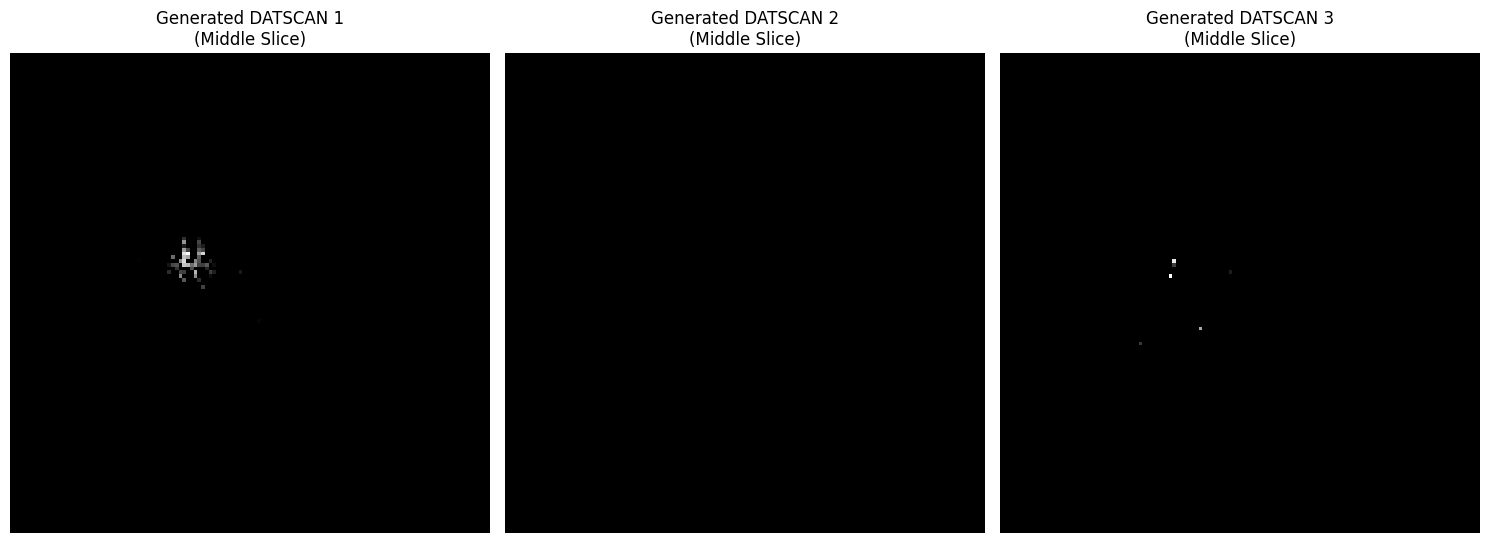

In [48]:
# Cell 30 (Modified): Generate new DATSCAN images from the trained VAE
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_datscan_image(model_path='datscan_vae.pt', device=device):
    # Load the trained model
    loaded_model = DATScanVAE(latent_dim=32).to(device)
    
    # Load the checkpoint and extract just the model state dict
    checkpoint = torch.load(model_path)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.eval()
    
    with torch.no_grad():
        # Use the model's generate method instead of manual sampling and decoding
        generated_images = loaded_model.generate(num_samples=1, device=device)
        
        # Move to CPU and convert to numpy for visualization
        generated_image = generated_images.cpu().squeeze().numpy()
        
        # Since your model uses sigmoid activation in the decoder, 
        # the output is already normalized between 0 and 1
        return generated_image

# Generate and visualize multiple images
plt.figure(figsize=(15, 15))
for i in range(3):  # Generate 3 different images
    plt.subplot(1, 3, i+1)
    generated_img = generate_datscan_image()
    
    # Since these are 3D images (128x128x128), let's show a middle slice
    middle_slice = generated_img.shape[2] // 2  # Taking middle slice along z-axis
    plt.imshow(generated_img[:, :, middle_slice], cmap='gray')
    plt.title(f'Generated DATSCAN {i+1}\n(Middle Slice)')
    plt.axis('off')
plt.tight_layout()
plt.show()

# TESTING 3D

In [ ]:
# Cell 31: Interactive 3D DATSCAN Viewer
import ipywidgets as widgets
from IPython.display import display

def create_3d_viewer(volume):
    """
    Create an interactive viewer for 3D volumes using ipywidgets.
    Args:
        volume: 3D numpy array (height x width x depth)
    """
    # Create sliders for each dimension
    z_slider = widgets.IntSlider(
        value=volume.shape[2]//2,
        min=0,
        max=volume.shape[2]-1,
        description='Z-slice:',
        continuous_update=False
    )
    
    y_slider = widgets.IntSlider(
        value=volume.shape[1]//2,
        min=0,
        max=volume.shape[1]-1,
        description='Y-slice:',
        continuous_update=False
    )
    
    x_slider = widgets.IntSlider(
        value=volume.shape[0]//2,
        min=0,
        max=volume.shape[0]-1,
        description='X-slice:',
        continuous_update=False
    )
    
    # Create radio buttons for view selection
    view_selector = widgets.RadioButtons(
        options=['Axial (Z)', 'Coronal (Y)', 'Sagittal (X)'],
        description='View:',
        disabled=False
    )
    
    # Create the output widget for the plot
    out = widgets.Output()
    
    # Define the update function
    def update(change):
        with out:
            out.clear_output(wait=True)
            plt.figure(figsize=(8, 8))
            
            if view_selector.value == 'Axial (Z)':
                plt.imshow(volume[:, :, z_slider.value], cmap='gray')
                plt.title(f'Axial Slice {z_slider.value}')
            elif view_selector.value == 'Coronal (Y)':
                plt.imshow(volume[:, y_slider.value, :], cmap='gray')
                plt.title(f'Coronal Slice {y_slider.value}')
            else:  # Sagittal
                plt.imshow(volume[x_slider.value, :, :], cmap='gray')
                plt.title(f'Sagittal Slice {x_slider.value}')
            
            plt.colorbar(label='Intensity')
            plt.axis('on')
            plt.show()
    
    # Register the update function
    z_slider.observe(update, names='value')
    y_slider.observe(update, names='value')
    x_slider.observe(update, names='value')
    view_selector.observe(update, names='value')
    
    # Create the layout
    controls = widgets.VBox([view_selector, x_slider, y_slider, z_slider])
    viewer = widgets.HBox([controls, out])
    
    # Show initial plot
    update({'new': z_slider.value})
    
    return viewer

# Generate a new DATSCAN image and create the viewer
generated_img = generate_datscan_image()
viewer = create_3d_viewer(generated_img)
display(viewer)

C:\Users\alexc\AppData\Local\Temp\ipykernel_107852\2958803006.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
